In [20]:
import polars as pl
import os
from datetime import datetime
from datetime import timezone
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# local imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.sbs_times import sbs_times

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

In [9]:
# 10m preprocessed acropolis data
df_acropolis = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_cal_corr_acropolis.parquet"))
  
# 10m preprocessed picarro data
df_p_10m = pl.scan_parquet(os.path.join(DATA_DIRECTORY,"processed", "10m_cal_corr_picarro.parquet"))

In [10]:
df_acropolis.head(5).collect()

system_name,sys_name_short,creation_timestamp,gmp343_raw,gmp343_compensated,gmp343_filtered,gmp343_temperature,wxt532_speed_avg,wxt532_speed_min,wxt532_speed_max,wxt532_direction_avg,wxt532_direction_min,wxt532_direction_max,wxt532_last_update_time,raspi_cpu_usage,raspi_cpu_temperature,raspi_disk_usage,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,sht45_humidity,sht45_temperature,bme280_humidity,bme280_temperature,bme280_pressure,cal_bottle_id,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,cal_gmp343_temperature,cal_bme280_temperature,cal_bme280_humidity,cal_bme280_pressure,cal_sht45_temperature,cal_sht45_humidity,revision,receipt_timestamp,raspi_memory_usage,wxt532_temperature,wxt532_heating_voltage,wxt532_supply_voltage,wxt532_reference_voltage,ups_battery_error_detected,ups_battery_above_voltage_threshold,ups_battery_is_fully_charged,ups_powered_by_grid,h2o_ah,h2o_v%,gmp343_dry,system_id,slope,intercept,CO2_corr,gmp343_corrected,diff,date
str,str,"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,"datetime[ns, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date
"""tum-esm-midcos…","""mid-cost-7""",2023-06-26 13:00:00 UTC,450.484211,497.989474,497.989474,28.757895,null,null,null,null,null,null,null,null,null,null,null,null,null,34.308947,27.824211,34.75,27.674737,948.002105,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,9.734438,1.430735,505.217802,7.0,null,null,423.60248,null,null,2023-06-26
"""tum-esm-midcos…","""mid-cost-7""",2023-06-26 14:00:00 UTC,460.543,513.1945,513.1945,30.4335,null,null,null,null,null,null,null,null,null,null,null,null,null,30.3898,30.2435,30.66665,30.08105,947.32375,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,9.443418,1.396665,520.463628,7.0,null,null,423.399361,null,null,2023-06-26
"""tum-esm-midcos…","""mid-cost-7""",2023-06-27 08:00:00 UTC,468.941441,510.55086,510.55086,26.47371,null,null,null,null,null,null,null,null,null,null,null,null,null,32.186888,25.79122,33.021532,25.651163,952.482932,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,8.05087,1.168825,516.584898,7.0,null,null,426.05217,null,null,2023-06-27
"""tum-esm-midcos…","""mid-cost-7""",2023-06-27 15:00:00 UTC,364.943103,413.348276,413.348276,31.696552,null,null,null,null,null,null,null,null,null,null,null,null,null,24.711897,30.866379,25.083103,30.722931,937.658103,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,8.217625,1.233009,418.508524,7.0,null,null,417.728367,null,null,2023-06-27
"""tum-esm-midcos…","""mid-cost-7""",2023-06-27 16:00:00 UTC,371.325192,413.441885,413.441885,31.734642,null,null,null,null,null,null,null,null,null,null,null,null,null,25.65519,30.495663,26.00569,30.356577,950.372286,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,8.547071,1.265263,418.740029,7.0,null,null,418.137354,null,null,2023-06-27


In [11]:
all_systems = []

#--- events during sbs

# cut roof-top power out
before = df_acropolis.filter(pl.col("creation_timestamp") < datetime(2024, 1, 15, 18, 0, 0).replace(tzinfo=timezone.utc))
after = df_acropolis.filter(pl.col("creation_timestamp") > datetime(2024, 1, 17, 0, 0, 0).replace(tzinfo=timezone.utc))
    
df_acropolis = pl.concat([before, after], how="diagonal")

# cut inlet change
before = df_acropolis.filter(pl.col("creation_timestamp") < datetime(2024, 2, 5, 13, 0, 0).replace(tzinfo=timezone.utc))
after = df_acropolis.filter(pl.col("creation_timestamp") > datetime(2024, 2, 5, 15, 30, 0).replace(tzinfo=timezone.utc))
    
df_acropolis = pl.concat([before, after], how="diagonal")

# cut inlet maintainence
before = df_acropolis.filter(pl.col("creation_timestamp") < datetime(2024, 2, 13, 10, 30, 0).replace(tzinfo=timezone.utc))
after = df_acropolis.filter(pl.col("creation_timestamp") > datetime(2024, 2, 13, 12, 0, 0).replace(tzinfo=timezone.utc))
    
df_acropolis = pl.concat([before, after], how="diagonal")

#---

for id, start_date, end_date in sbs_times:
    print(f"processing {id}")
    
    #cut maintainence / power outtage from 23.01.2024
    if id in [10,11,13]:
        before = df_acropolis.filter(pl.col("creation_timestamp") < datetime(2024, 1, 23, 14, 0, 0).replace(tzinfo=timezone.utc))
        after = df_acropolis.filter(pl.col("creation_timestamp") > datetime(2024, 1, 25, 23, 59, 59).replace(tzinfo=timezone.utc))
        
        df_acropolis = pl.concat([before, after], how="diagonal")
    
    #-------

    df_filtered = df_acropolis.filter(pl.col("creation_timestamp").is_between(start_date, end_date))  \
        .filter(pl.col("CO2_corr") > 0) \
        .filter(pl.col("gmp343_filtered") > 0) \
        .filter(pl.col("system_id") == id)  \
        .collect()
        
    mean = df_filtered["slope"].mean()
    std = df_filtered["slope"].std()

    df_std = df_filtered.with_columns((((mean - 2*std) < pl.col("slope")) & (pl.col("slope")  < (mean + 2*std))).alias("slope_2_std_selector"))
        
    calibrations_2_std = df_std.filter(pl.col("slope_2_std_selector") == True).select("creation_timestamp","slope", "intercept") \
        .rename({"slope":"slope_2_std","intercept":"intercept_2_std"})

    df_filtered = df_filtered.sort("creation_timestamp") \
        .join(calibrations_2_std, on = ["creation_timestamp"], how= "left") \
        .interpolate()
        
    df_filtered = df_filtered.with_columns([
        ((pl.col("gmp343_dry")) * pl.col("slope_2_std") + pl.col("intercept_2_std")).alias("gmp343_corrected_2_std")
                            ]) \
        .with_columns([
            (pl.col("CO2_corr") - pl.col("gmp343_corrected_2_std")).alias("diff_2_std"),
            (np.square(np.subtract(pl.col("CO2_corr"), pl.col("gmp343_corrected"))).mean()).alias("mse_full_deployment"),
            (np.square(np.subtract(pl.col("CO2_corr"), pl.col("gmp343_corrected_2_std"))).mean()).alias("mse_2_std_full_deployment")
                    ]) \
        .with_columns([
            pl.col("mse_full_deployment").sqrt().alias("rmse_full_deployment"),
            pl.col("mse_2_std_full_deployment").sqrt().alias("rmse_2_std_full_deployment")
                    ]) 
        
    all_systems.append(df_filtered)
    

processing 1
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 18
processing 20


In [12]:
df_all_sbs_filtered = pl.concat(all_systems, how="diagonal")
df_all_sbs_filtered.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_sbs_rmse_acropolis.parquet"))

In [13]:
df_all_sbs_filtered = df_all_sbs_filtered.with_columns(pl.lit("Munich").alias("Mid-Cost Network"))

In [16]:
fig = px.histogram(df_filtered, x="slope")
fig.show()
fig = px.histogram(df_std, x="slope", color="slope_2_std_selector")
fig.show()

fig = px.line(df_all_sbs_filtered, x="creation_timestamp", y="diff", color = "system_name")
fig.show()
fig = px.line(df_all_sbs_filtered, x="creation_timestamp", y="diff_2_std", color = "system_name")
fig.show()

fig = px.scatter(df_all_sbs_filtered, x="system_name", y=["rmse_full_deployment","rmse_2_std_full_deployment"])
fig.show()

In [17]:
# 144 * 10 minute intervals in 1 day - 3 * 10 min intervals in one calibration
# 24* 1h interval in 1 day

df_plot = df_all_sbs_filtered.sort("creation_timestamp") \
    .group_by("system_name") \
    .agg([(pl.col("gmp343_corrected").count() / 24).alias("sbs_days"),
          pl.col("system_id"),
          ]) \
    .with_columns((pl.col("sbs_days") > 14).alias("days_threshold")) \
    .sort("sbs_days")
    
fig = px.scatter(df_plot, x="system_name", y="sbs_days", color="days_threshold")
fig.show()

In [18]:
df_plot = df_all_sbs_filtered.rename({"rmse_2_std_full_deployment":"RMSE (ppm)"}) \
    .join(df_plot, on="system_name", how="left")

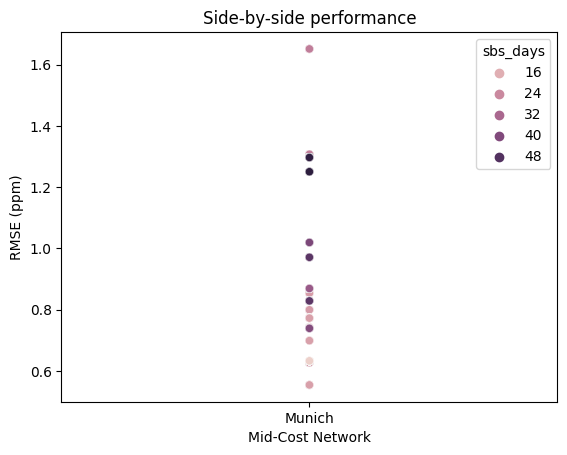

In [21]:
sns.scatterplot(data=df_plot,x='Mid-Cost Network',y='RMSE (ppm)', hue="sbs_days", alpha=0.5).set(title='Side-by-side performance')
plt.show()